# Deep Learning - Transfer Learning using CNNs
In this notebook, we attempt to implement transfer learning with ResNet-18 to perform classification of cats vs dogs. We will experiment with different modifications to the original ResNet to see which has better performance.

We first import the necessary libraries:

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
from torchvision import datasets, models, transforms
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

## (a) Preparing the Data

We start by downloading the raw dataset from Kaggle. The dataset contains 25k images of cats and dogs in a single folder, labelled by their filename (e.g. cat.001.png). We first load the filenames into a list, and then split accordingly into train, test and val sets:

In [3]:
#Define directory
data_dir = './data'
#Read filenames
cat_filenames = []
dog_filenames = []
for fileName in os.listdir(data_dir):
    if 'cat' in fileName:
        cat_filenames.append(os.path.join(data_dir,fileName))
    else:
        dog_filenames.append(os.path.join(data_dir,fileName))
random.shuffle(cat_filenames)
random.shuffle(dog_filenames)
#Train,Val,Test Splits
train_split = 8000
val_split = 1000
test_split = 1000

train_filenames, test_filenames, val_filenames = [], [], []
for i in range(train_split):
    train_filenames.append(cat_filenames[i])
    train_filenames.append(dog_filenames[i]) 
for i in range(train_split,train_split+val_split):
    val_filenames.append(cat_filenames[i])
    val_filenames.append(dog_filenames[i])
for i in range(train_split+val_split, train_split+val_split+test_split):
    test_filenames.append(cat_filenames[i])
    test_filenames.append(dog_filenames[i])

#Shuffle Train, Val, Test Filenames
random.shuffle(train_filenames)
random.shuffle(val_filenames)
random.shuffle(test_filenames)

print('Train Set Length: ',len(train_filenames))
print('Val Set Length: ',len(val_filenames))
print('Test Set Length: ', len(test_filenames))

Train Set Length:  16000
Val Set Length:  2000
Test Set Length:  2000


We create a custom torch Dataset class to help load our data. We also define transforms to augment our images to help our model generalize better. Finally, we initialize torch dataloaders that will be used to feed in batches of data to our network:

In [5]:
import copy

#Define Image Augumentations
train_transform = A.Compose([
    A.RandomResizedCrop(224, 224),
    A.HorizontalFlip(),
    A.Normalize(),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(),
    ToTensorV2()
])

#Define Dataset Class
class CatsAndDogsDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, transform=None):
        super().__init__()
        self.filenames = filenames
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_filepath = self.filenames[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if 'cat' in image_filepath:
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label, idx

train_set = CatsAndDogsDataset(train_filenames, train_transform)
val_set = CatsAndDogsDataset(val_filenames, test_transform)
test_set = CatsAndDogsDataset(test_filenames, test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

image, label, _ = next(iter(train_loader))
print(image.shape, label.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


## (b) Initialize the ResNet-18 model and (c) loading pre-trained weights
We load the ResNet-18 model from torchvision with the pre-trained ImageNet weights:

In [5]:
from torchvision import models

#Initialize resnet-18 and load pretrained weights
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## (d) Replacing last layer in pretrained model
The ResNet-18 model has a final 512 node linear layer that outputs 1000 classes. We replace this with a 512 node linear layer that outputs only 1 value (since we are doing binary classification) followed by a sigmoid function:

In [6]:
#Replace last layer
model.fc = torch.nn.Sequential(torch.nn.Linear(512, 1), torch.nn.Sigmoid())
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## (e) Freeze weights of the pre-trained model
We freeze the weights of all layers except for the new layers we added:

In [7]:
#Freeze all layers
for param in model.parameters():
    param.requires_grad = False
#Unfreeze last layer
for param in model.fc.parameters():
    param.requires_grad = True

## (f) Fine-tuning the network
We fine-tune the network on the dataset. We train for 15 epochs with a learning rate of $10^{-4}$. For the training, we define a helper function which continuously saves the best model based on the validation accuracy:

In [6]:
import copy

device = torch.device('mps')

def train(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model.to(device)
    loss_history = []
    acc_history = []
    best_acc = 0.
    best_model_wts = copy.deepcopy(model.state_dict())
    #Iterate epochs
    for epoch in range(epochs):
        print('Training epoch {}/{}...:'.format(epoch+1, epochs))
        #Each epoch has a training phase and validation phase
        for phase in ['train','val']:
            data_loader = None
            if phase == 'train':
                #Set train mode
                model.train()
                data_loader = train_loader
            else:
                #Set Eval mode
                model.eval()
                data_loader = val_loader

            running_loss = 0.
            running_corrects = 0
            #Iterate batches
            for inputs, labels, _ in data_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                optimizer.zero_grad()
                #Set gradient calc on only for training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.squeeze(model(inputs), 1)
                    loss = criterion(outputs, labels)
                    preds = (outputs>0.5).float()
                    #Do backprop if phase = train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.float() / len(data_loader.dataset)
            print('{} loss: {}, {} acc: {}'.format(phase, epoch_loss, phase, epoch_acc))
            if phase == 'val':
                loss_history.append(epoch_loss)
                acc_history.append(epoch_acc)
            #Saving best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print('-'*20)
    print('Best val acc: {}'.format(best_acc))
    #Load best weights saved
    model.load_state_dict(best_model_wts)
    return model, loss_history, acc_history
        

In [9]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
model, loss_hist, acc_hist = train(model, train_loader, val_loader, optimizer, criterion, epochs=5)

Training epoch 1/5...:
train loss: 0.4630205540060997, train acc: 0.8185625672340393
val loss: 0.23115037202835084, val acc: 0.955500066280365
--------------------
Training epoch 2/5...:
train loss: 0.27700487089157105, train acc: 0.9102500677108765
val loss: 0.1461086630821228, val acc: 0.9660000205039978
--------------------
Training epoch 3/5...:
train loss: 0.22519029228389262, train acc: 0.9210625290870667
val loss: 0.11292630660533905, val acc: 0.9695000648498535
--------------------
Training epoch 4/5...:
train loss: 0.20074166156351567, train acc: 0.9261875152587891
val loss: 0.09277565109729767, val acc: 0.9725000262260437
--------------------
Training epoch 5/5...:
train loss: 0.19219593042135238, train acc: 0.9261250495910645
val loss: 0.08539836603403092, val acc: 0.9720000624656677
--------------------
Best val acc: 0.9725000262260437


Our model achieves ~97% accuracy on the validation set. We evaluate the performance on the test set. We define a helper function to evaluate accuracy:

In [7]:
def test_accuracy(model, test_loader):
    running_corrects = 0
    model.to(device)
    model.eval()
    for inputs, labels, _ in test_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        outputs = torch.squeeze(model(inputs), 1)
        preds = (outputs>0.5).float()
        running_corrects += torch.sum(preds == labels)
    return (running_corrects.float() / len(test_loader.dataset)).item()

In [10]:
print('Test Accuracy: ',test_accuracy(model, test_loader))

Test Accuracy:  0.9745000600814819


## (h) Unfreeze all layers and (i) continue training
We unfreeze all the layers of the network and continue the fine-tuning. We use a lower learning rate this time ($10^{-5}$):

In [11]:
#Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

#Train again
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss()
model, loss_hist, acc_hist = train(model, train_loader, val_loader, optimizer, criterion, epochs=5)


Training epoch 1/5...:
train loss: 0.14474837996065618, train acc: 0.9411875605583191
val loss: 0.03700193827599287, val acc: 0.9865000247955322
--------------------
Training epoch 2/5...:
train loss: 0.1104289725907147, train acc: 0.9533125162124634
val loss: 0.02941668276488781, val acc: 0.9890000224113464
--------------------
Training epoch 3/5...:
train loss: 0.10197074206126854, train acc: 0.9577500224113464
val loss: 0.028461136588826777, val acc: 0.9900000691413879
--------------------
Training epoch 4/5...:
train loss: 0.09520305647701024, train acc: 0.960437536239624
val loss: 0.02308495113067329, val acc: 0.9910000562667847
--------------------
Training epoch 5/5...:
train loss: 0.08751604202575981, train acc: 0.9625625610351562
val loss: 0.02277267962694168, val acc: 0.9905000329017639
--------------------
Best val acc: 0.9910000562667847


## (j) Evaluate Test Accuracy again
Our model achieves ~99% validation accuracy after unfreezing and training. We check the test accuracy again:

In [12]:
print('Test Accuracy after unfreezing and training: ', test_accuracy(model, test_loader))

Test Accuracy after unfreezing and training:  0.9910000562667847


### Note: 
Part (k) is covered already in the train() function which we wrote above, since it continuously evaluates the validation accuracy and saves the best weights.

## (l) Visualizing our model's incorrect predictions
We next display some of our model's mistakes using a helper function:

In [8]:
#Helper function to visualize images + predictions
def visualize_errors(model, test_loader):
    mistakes = 0
    mistake_images = []
    mistake_preds = []
    while mistakes <= 3:
        inputs, labels, indices = next(iter(test_loader))
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        outputs = torch.squeeze(model(inputs), 1)
        preds = (outputs>0.5).float()
        for index, image in enumerate(inputs):
            if preds[index].item() != labels[index].item():
                mistakes += 1
                mistake_images.append(test_filenames[indices[index]])
                pred = 'cat' if preds[index].item() == 1.0 else 'dog'
                mistake_preds.append(pred)

    fig = plt.figure(figsize=(10,8))
    rows = 1
    cols = 4
    for index, filename in enumerate(mistake_images[:4]):
        original_image = cv2.imread(filename)
        fig.add_subplot(rows, cols, index+1)
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(mistake_preds[index])
    plt.show()

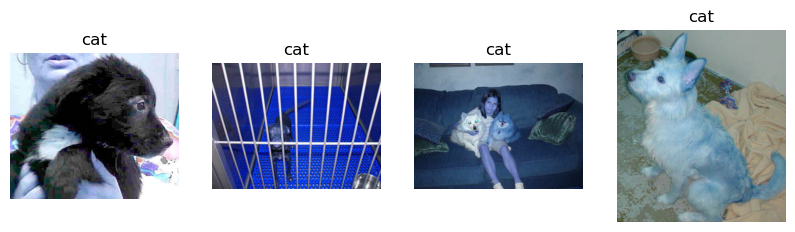

In [13]:
visualize_errors(model, test_loader)

## (m) Experimenting with keeping the last fc layer
Now, we repeat by keeping the 512x1000 fc layer. We add a ReLU layer after this, along with a 1000x1 linear layer and a Sigmoid layer which serves as our classifier:

In [14]:
model2 = models.resnet18(pretrained=True)
model2.fc = torch.nn.Sequential(torch.nn.Linear(512,1000), torch.nn.ReLU(), torch.nn.Linear(1000,1), torch.nn.Sigmoid())
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

First, we freeze all layers except the last FC layers and train:

In [15]:
#Freeze all layers
for param in model2.parameters():
    param.requires_grad = False
#Unfreeze FC layers
for param in model2.fc.parameters():
    param.requires_grad = True

#Train
optimizer = torch.optim.Adam(model2.fc.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
model2, loss_hist, acc_hist = train(model2, train_loader, val_loader, optimizer, criterion, epochs=5)

Training epoch 1/5...:
train loss: 0.20450204475224018, train acc: 0.9173750281333923
val loss: 0.05500831687450409, val acc: 0.9805000424385071
--------------------
Training epoch 2/5...:
train loss: 0.1576550717279315, train acc: 0.9323750734329224
val loss: 0.046862856030464174, val acc: 0.9815000295639038
--------------------
Training epoch 3/5...:
train loss: 0.1509309983737767, train acc: 0.9353125691413879
val loss: 0.049985257372260096, val acc: 0.9810000658035278
--------------------
Training epoch 4/5...:
train loss: 0.15272382823005318, train acc: 0.9339375495910645
val loss: 0.051554851159453394, val acc: 0.9800000190734863
--------------------
Training epoch 5/5...:
train loss: 0.1437066023312509, train acc: 0.937000036239624
val loss: 0.0430835003182292, val acc: 0.9800000190734863
--------------------
Best val acc: 0.9815000295639038


In [16]:
#Evaluate test accuracy
print('Test Accuracy: ',test_accuracy(model2, test_loader))      

Test Accuracy:  0.9805000424385071


We get a higher test accuracy this time after just training the FC layers. We now unfreeze the full network and train with a lower learning rate:

In [17]:
#Unfreeze all layers
for param in model2.parameters():
    param.requires_grad = True

#Train again
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss()
model2, loss_hist, acc_hist = train(model2, train_loader, val_loader, optimizer, criterion, epochs=5)
#Evaluate Test Accuracy after unfreezing
print('Test Accuracy after unfreezing and training: ', test_accuracy(model2, test_loader))

Training epoch 1/5...:
train loss: 0.1329465184994042, train acc: 0.9418125152587891
val loss: 0.03158298152498901, val acc: 0.9855000376701355
--------------------
Training epoch 2/5...:
train loss: 0.10675693829916418, train acc: 0.9553125500679016
val loss: 0.029670515383593738, val acc: 0.9905000329017639
--------------------
Training epoch 3/5...:
train loss: 0.10116899026371538, train acc: 0.9571875333786011
val loss: 0.024704065705649553, val acc: 0.9905000329017639
--------------------
Training epoch 4/5...:
train loss: 0.0918846626393497, train acc: 0.9620625376701355
val loss: 0.02487509352294728, val acc: 0.9895000457763672
--------------------
Training epoch 5/5...:
train loss: 0.08315697651030496, train acc: 0.9661875367164612
val loss: 0.027213428663089873, val acc: 0.9910000562667847
--------------------
Best val acc: 0.9910000562667847
Test Accuracy after unfreezing and training:  0.9890000224113464


It appears that our model performed slightly worse on the test set after keeping the last fc layer, compared to the previous model which did not have the last fc layer. Finally, we visualize some of the mistakes of our model:

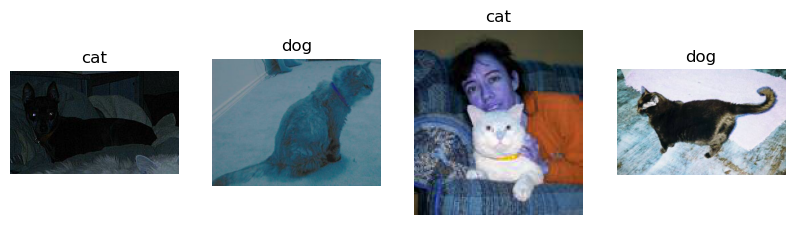

In [18]:
visualize_errors(model2, test_loader)

## (n) Use any other CNN model to perform transfer learning
In this section, we attempt to train another CNN model - MobileNet. This is an efficient network that uses an inverted residual structure and is optimized for speed and memory. We first initialize the model with pretrained weights (imagenet weights):

In [9]:
model3 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
print(model3)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

The final classifier has a dropout layer followed by a 1280x1000 linear layer. We replace this with our linear layer with output shape 1280x1:

In [10]:
#Replace classifier
model3.classifier = torch.nn.Sequential(torch.nn.Dropout(p = 0.2, inplace=False), torch.nn.Linear(1280, 1, bias=True), torch.nn.Sigmoid())
#Freeze all layers
for param in model3.parameters():
    param.requires_grad = False
#Unfreeze classifier
for param in model3.classifier.parameters():
    param.requires_grad = True


Now we train our model and evaluate it on the test set:

In [11]:
#Train
optimizer = torch.optim.Adam(model3.classifier.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
model3, loss_hist, acc_hist = train(model3, train_loader, val_loader, optimizer, criterion, epochs=5)
#Evaluate test accuracy
print('Test Accuracy: ',test_accuracy(model3, test_loader))

Training epoch 1/5...:
train loss: 0.5271272681951523, train acc: 0.8094375133514404
val loss: 0.3319722468852997, val acc: 0.9510000348091125
--------------------
Training epoch 2/5...:
train loss: 0.3628906057476997, train acc: 0.8857500553131104
val loss: 0.23261782574653625, val acc: 0.9485000371932983
--------------------
Training epoch 3/5...:
train loss: 0.30544072422385216, train acc: 0.8938750624656677
val loss: 0.18283767640590667, val acc: 0.955500066280365
--------------------
Training epoch 4/5...:
train loss: 0.27435862231254576, train acc: 0.897937536239624
val loss: 0.1590329567193985, val acc: 0.9580000638961792
--------------------
Training epoch 5/5...:
train loss: 0.26062625223398206, train acc: 0.8997500538825989
val loss: 0.14292771589756012, val acc: 0.9590000510215759
--------------------
Best val acc: 0.9590000510215759
Test Accuracy:  0.956000030040741


We unfreeze the whole network and train with a lower learning rate:

In [12]:
#Unfreeze whole network
for param in model3.parameters():
    param.requires_grad = True
#Train again
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss()
model3, loss_hist, acc_hist = train(model3, train_loader, val_loader, optimizer, criterion, epochs=5)
#Evaluate test accuracy
print('Test Accuracy after unfreezing and training: ',test_accuracy(model3, test_loader))

Training epoch 1/5...:
train loss: 0.21322119744122028, train acc: 0.9124375581741333
val loss: 0.07400564563274384, val acc: 0.9785000681877136
--------------------
Training epoch 2/5...:
train loss: 0.16454634016007186, train acc: 0.9341250658035278
val loss: 0.0578501777946949, val acc: 0.9795000553131104
--------------------
Training epoch 3/5...:
train loss: 0.1512910657413304, train acc: 0.9360000491142273
val loss: 0.050073125973343846, val acc: 0.983500063419342
--------------------
Training epoch 4/5...:
train loss: 0.14445258037373424, train acc: 0.9388750195503235
val loss: 0.046184046432375905, val acc: 0.9845000505447388
--------------------
Training epoch 5/5...:
train loss: 0.1321767921857536, train acc: 0.94468754529953
val loss: 0.044329089246690274, val acc: 0.9830000400543213
--------------------
Best val acc: 0.9845000505447388
Test Accuracy after unfreezing and training:  0.987000048160553


Finally, we again check our model's errors on the test set using the helper function we defined earlier:

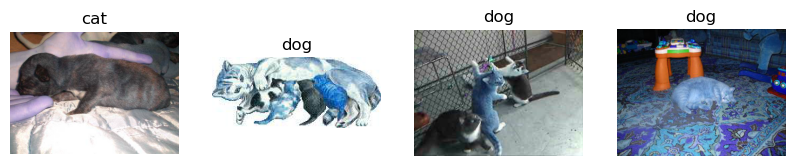

In [13]:
visualize_errors(model3, test_loader)